In [1]:
# default_exp gan.learner

# gan.learner

> API details.

In [2]:
# export

import pandas as pd
import numpy as np
import torch
import os
import torch.nn as nn
import matplotlib.pyplot as plt

from tqdm import tqdm
from fastai.basics import set_seed
from fastrenewables.synthetic_data import *
from fastrenewables.gan.model import *
from fastrenewables.tabular.model import EmbeddingModule

from sklearn.model_selection import train_test_split

import torch.nn.functional as F

plt.style.use('seaborn-colorblind')

#import glob

In [3]:
# export

class GANLearner():
    def __init__(self, gan, n_gen=1, n_dis=1):
        super(GANLearner, self).__init__()
        # gan should contain a class which itself contains a generator and discriminator/critic class and combines them
        self.gan = gan
        self.n_gen = n_gen
        self.n_dis = n_dis
   
    def generate_samples(self, x_cat, x_cont):
        with torch.no_grad():
            z = self.gan.noise(x_cont)
            fake_samples = self.gan.generator(x_cat, z)
        return fake_samples
    
    def fit(self, dl, epochs=10, lr=1e-3, plot_epochs=10, save_model=False, save_dir='models/', save_file='tmp', figsize=(16, 9)):
        
        self.gan.to_device(torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
        self.gan.gen_optim.param_groups[0]['lr'] = lr
        self.gan.dis_optim.param_groups[0]['lr'] = lr
        
        self.gan.train()
        
        for e in tqdm(range(epochs)):
            for x_cat, x_cont, y in dl:
                x_cat = x_cat.to(self.gan.device).long()
                x_cont = x_cont.to(self.gan.device)
                y = y.to(self.gan.device)
                                
                for _ in range(self.n_dis):
                    self.gan.train_discriminator(x_cat, x_cont, y)

                for _ in range(self.n_gen):
                    self.gan.train_generator(x_cat, x_cont, y)
                
            #if (e+1)%plot_epochs==0:
                #plt.figure(figsize=figsize)
                #plt.plot(self.gan.real_loss, label='Real Loss')
                #plt.plot(self.gan.fake_loss, label='Fake Loss')
                #if len(self.gan.aux_loss) > 0:
                #    plt.plot(self.gan.aux_loss, label='Aux Loss')
                #plt.legend()
                #plt.show()
                
                #fig, ax1 = plt.subplots(figsize=figsize)
                #ax1.set_xlabel('iterations')
                #ax1.set_ylabel('bce loss')
                #ax1.plot(self.gan.real_loss, label='real', color='red')
                #ax1.plot(self.gan.fake_loss, label='fake', color='blue') 
                #ax1.tick_params(axis='y')
                #ax1.legend(loc='upper right')
                #
                #ax2 = ax1.twinx()
                #ax2.set_ylabel('aux loss')
                #ax2.plot(self.gan.aux_loss, label='aux', color='green')
                #ax2.tick_params(axis='y')
                #ax2.legend(loc='lower right')
                #
                #fig.tight_layout()
                #plt.show()
        
        self.gan.eval()
        
        if save_model:
            self.gan.to_device('cpu')
            if not os.path.exists(save_dir):
                os.mkdir(save_dir)
            torch.save(self.gan.state_dict(), save_dir+save_file+'.pt')
        
        return

### Examples:

In [4]:
# hide

n_samples = 2**12
n_classes = 4
n_features = 1
batch_size = 2**9
n_z = 10
n_in = n_features
n_hidden = 256
epochs = 1
lr = 5e-5
n_gen = 1
n_dis = 1

data = GaussianDataset(n_samples, n_classes)
train_data, test_data = torch.utils.data.random_split(data, [int(len(data)*3/4), int(len(data)*1/4)])

train_dl = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_dl = torch.utils.data.DataLoader(test_data, batch_size=len(test_data), shuffle=True, drop_last=True)

In [5]:
# export

def evaluate_gan(gan_type='bce', aux_factor=1, epochs=10):
    
    print(gan_type, aux_factor)
    set_seed(1337)
    emb_module = EmbeddingModule(categorical_dimensions=[n_classes+1])
    model = get_gan_model(structure=[n_z, n_hidden, n_hidden, n_in], n_classes=n_classes, emb_module=emb_module, gan_type=gan_type, aux_factor=aux_factor, label_noise=0.1, label_bias=0.25)
    learner = GANLearner(gan=model, n_gen=n_gen, n_dis=n_dis)
    learner.fit(train_dl, epochs=epochs, lr=lr, plot_epochs=epochs, save_model=True)
    for x_cat, x_cont, y in test_dl:
        x_cat = x_cat.long()
        print('distribution of real data:')
        d_real = fit_kde(x_cont, bandwidth=1/25, show_plot=True)
        x_fake = learner.generate_samples(x_cat, x_cont)
        print('distribution of generated data:')
        d_fake = fit_kde(x_fake, bandwidth=1/25, show_plot=True)
        break
    kld = calculate_kld(d_real, d_fake)
        
    return kld

aux 1


100%|██████████| 10/10 [00:05<00:00,  1.84it/s]


distribution of real data:


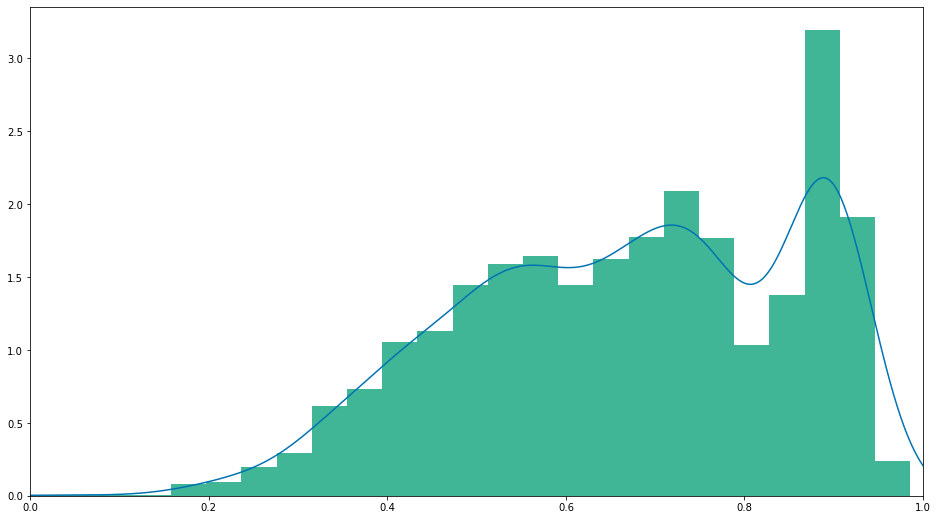

distribution of generated data:


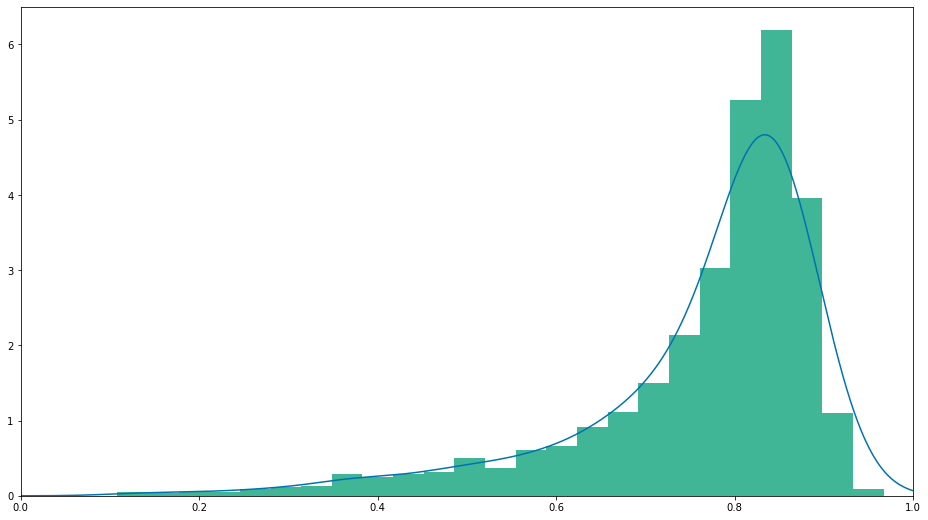

0.31606438364222716

In [6]:
# hide

evaluate_gan('aux')

In [7]:
#epochs = 100
#
#bce_kld = evaluate_gan('bce', 1, epochs)
#
#afs = [4, 2, 1, 1/2, 1/4]
#klds = [evaluate_gan('aux', af, epochs) for af in afs]
#
#afs.append(0)
#klds.append(bce_kld)
#
#data = {'aux_factor': afs,
#       'kld': klds}
#
#df = pd.DataFrame(data)
#df.to_csv('klds.csv', index=False)

In [8]:
#df = pd.read_csv('klds.csv')
#df
#
#afs = df['aux_factor'].values
#klds = df['kld'].values
#
#plt.figure(figsize=(16, 9))
#plt.plot(afs[:-1], klds[:-1], 'o--', label='auxiliary')
#plt.axhline(klds[-1], color='red', linestyle='--', label='conditional')
#plt.legend()
#plt.xscale('log',base=2) 
#plt.xticks(afs[:-1])
#plt.xlabel('auxiliary weighting factor')
#plt.ylabel('KLD')
#plt.show()